In [3]:
from __future__ import absolute_import
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Container
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
from keras.objectives import *
import keras_contrib.backend as KC
import keras.backend as K

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import scipy.misc
from PIL import Image, ImageOps
import shutil
from tqdm import *

from skimage.measure import structural_similarity as ssim
# import cv2

%matplotlib inline

/Users/darko/Python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Config
# Constants
DATA_DIR = "./data"
SECRET_DIR = os.path.join(DATA_DIR, "secret1")
COVER_DIR = os.path.join(DATA_DIR, "cover1")
ORIGIN_DIR = os.path.join(DATA_DIR, "origin")

IMAGE_SIZE = 255

# Variable used to weight the losses of the secret and cover images
BETA = 0.2

In [5]:
# Image Preprocessing
def fixed_size(img_in, width, height):
    img_orig = Image.open(img_in)
    out = img_orig.resize((width, height), Image.ANTIALIAS)
    return out

In [6]:
# Dateset Creation
def load_dataset(num_images_per_class=20, total_images=800):
    X_secret = []
    X_cover = []
    X_origin = []
    k = 0
    
    origin_img = os.listdir(ORIGIN_DIR)
    img = image.load_img(os.path.join(ORIGIN_DIR, origin_img[0]))
    img_resize = fixed_size(os.path.join(ORIGIN_DIR, origin_img[0]), IMAGE_SIZE, IMAGE_SIZE)
    x = image.img_to_array(img_resize)
    X_origin.append(x)
    
    # Create cover training set
    for c in os.listdir(COVER_DIR):
        c_dir = os.path.join(COVER_DIR, c)
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for cover_name_i in c_imgs[0: num_images_per_class]:
            cover_i = image.load_img(os.path.join(c_dir, cover_name_i))
            cover_i_resize = fixed_size(os.path.join(c_dir, cover_name_i), IMAGE_SIZE, IMAGE_SIZE)
            x = image.img_to_array(cover_i_resize)
            if x.shape[2] == 1:
                print (x)
            else:
                X_cover.append(x)
    random.shuffle(X_cover)
    
    # Create secret training set
    train_imgs = os.listdir(SECRET_DIR)
    random.shuffle(train_imgs)
    for img_i in train_imgs[0: total_images]:
        k += 1
        img = image.load_img(os.path.join(SECRET_DIR, img_i))
        img_resize = fixed_size(os.path.join(SECRET_DIR, img_i), IMAGE_SIZE, IMAGE_SIZE)
        x = image.img_to_array(img_resize)
        if x.shape[2] == 1:
            k -= 1
            shutil.move(os.path.join(SECRET_DIR, img_i), os.path.join("./", img_i))
            print (x)
        else:
            X_secret.append(x)
#     if k <= total_images:
#         random.shuffle(train_imgs)
#         for img_i_tmp in train_imgs[0: total_images-k]:
#             img = image.load_img(os.path.join(SECRET_DIR, img_i_tmp))
#             img_resize = fixed_size(os.path.join(SECRET_DIR, img_i_tmp), IMAGE_SIZE, IMAGE_SIZE)
#             x = image.img_to_array(img_resize)
#             if x.shape[2] == 1:
#                 k -= 1
#                 shutil.move(os.path.join(SECRET_DIR, img_i_tmp), os.path.join("./", img_i_tmp))
#             else:
#                 X_secret.append(x)
    random.shuffle(X_secret)
    
    return np.array(X_secret), np.array(X_cover), np.array(X_origin)

Number of cover examples = 18
Number of secret examples = 18
X_cover shape: (18, 255, 255, 3)
X_secret shape: (18, 255, 255, 3)
[[[[0.15294118 0.10980392 0.05098039]
   [0.20784314 0.14901961 0.07843138]
   [0.19607843 0.14117648 0.07058824]
   ...
   [0.6039216  0.49411765 0.38039216]
   [0.6156863  0.5058824  0.39215687]
   [0.6        0.4862745  0.38431373]]

  [[0.12156863 0.08235294 0.03137255]
   [0.14117648 0.09803922 0.05098039]
   [0.20392157 0.13725491 0.07843138]
   ...
   [0.6313726  0.5137255  0.4       ]
   [0.6509804  0.53333336 0.41568628]
   [0.6117647  0.49411765 0.3882353 ]]

  [[0.04313726 0.01960784 0.00784314]
   [0.11764706 0.07058824 0.03137255]
   [0.13725491 0.09411765 0.04705882]
   ...
   [0.654902   0.5372549  0.4117647 ]
   [0.6666667  0.54901963 0.41960785]
   [0.627451   0.50980395 0.39607844]]

  ...

  [[0.41960785 0.3647059  0.3372549 ]
   [0.43529412 0.36862746 0.3372549 ]
   [0.5176471  0.4392157  0.39607844]
   ...
   [0.57254905 0.5137255  0.47450

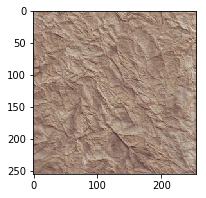

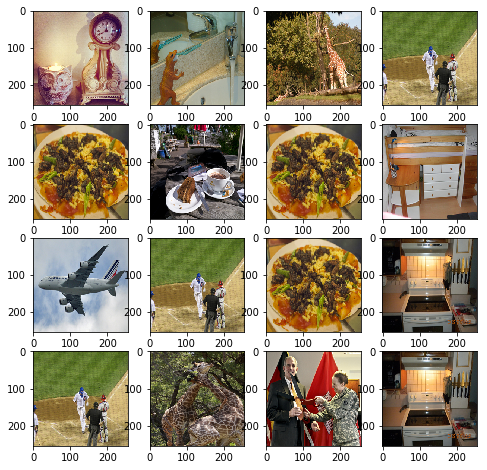

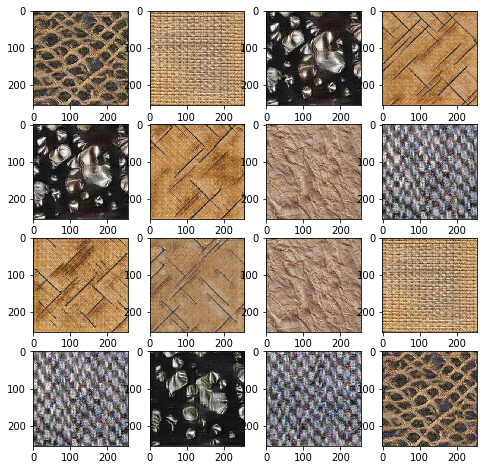

In [36]:
# Load dataset
X_secret_orig, X_cover_orig, X_origin = load_dataset()

# Normalize image vectors
X_cover = X_cover_orig/255
X_secret = X_secret_orig/255
X_origin = X_origin/255

# Print Statistics.
print("Number of cover examples = " + str(X_cover.shape[0]))
print("Number of secret examples = " + str(X_secret.shape[0]))
print("X_cover shape: " + str(X_cover.shape))
print("X_secret shape: " + str(X_secret.shape))

input_S = X_secret[0: X_secret.shape[0]]
input_C = X_cover[0: X_cover.shape[0]]
origin_img = X_origin[0: X_origin.shape[0]]
print (input_S)
fig4 = plt.figure(figsize=(3,3))
fig4.add_subplot(1, 1, 1)
plt.imshow(X_origin[0])
plt.savefig("img_origin.png")
# print input_C
# print input_C.shape

# Show sample images from the secret and cover dataset
fig1 = plt.figure(figsize=(8,8))
columns = 4
rows = 4
for i in range(1, columns*rows+1):
    # Randomly sample from secret dataset
    img_idx = np.random.choice(X_secret.shape[0])
    fig1.add_subplot(rows, columns, i)
    plt.imshow(X_secret[img_idx])
plt.show()
fig2 = plt.figure(figsize=(8,8))
columns = 4
rows = 4
for i in range(1, columns*rows+1):
    # Randomly sample from secret dataset
    img_idx = np.random.choice(X_cover.shape[0])
    fig2.add_subplot(rows, columns, i)
    plt.imshow(X_cover[img_idx])
plt.show()

In [8]:
# Loss for reveal network
def reveal_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return BETA * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hiding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = reveal_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return c_loss + s_loss

# def ssim_loss1(y_true, y_pred):
#     # Structural similarity using scikit
#     s = ssim(img1, img2)

def ssim_loss1(s_true, s_pred):
    
    s_true = KC.reshape(s_true, [-1] + list(KC.int_shape(s_pred)[1:]))
    s_pred = KC.reshape(s_pred, [-1] + list(KC.int_shape(s_pred)[1:]))

#     patches_pred = KC.extract_image_patches(s_pred, [1,3,3,1], [1,3,3,1], 'valid', K.image_data_format())
#     patches_true = KC.extract_image_patches(s_true, [1,3,3,1], [1,3,3,1], 'valid', K.image_data_format())
    patches_pred = tf.extract_image_patches(s_pred, [1,5,5,1], [1,2,2,1], [1,1,1,1], "SAME")
    patches_true = tf.extract_image_patches(s_true, [1,5,5,1], [1,2,2,1], [1,1,1,1], "SAME")
    
    # K1, K2 are two constants, much smaller than 1
    K1 = 0.01
    K2 = 0.03
    
    # mean, std, correlation
    mu_x = KC.mean(patches_pred)
    mu_y = KC.mean(patches_true)
    
    var_pred = K.var(patches_pred)
    var_true = K.var(patches_true)
#     sig_xy = (sig_x * sig_y) ** 0.5
#     sig_xy = K.mean(patches_pred * patches_true) - mu_x * mu_y
#     std_pred = K.sqrt(var_pred)
#     c2 = 0.03 ** 2
#     ssim = (2 * std_pred * std_true + c2)
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)
    
    # L, number of pixels, C1, C2, two constants
    L = 1
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2

    ssim = (2 * mu_x * mu_y + C1) * (2 * std_true * std_pred + C2) * 1.0 / ((mu_x ** 2 + mu_y ** 2 + C1) * (var_pred + var_true + C2))

#     ssim = (2 * mu_x * mu_y + C1) * (2 * sig_xy + C2) * 1.0 / ((mu_x ** 2 + mu_y ** 2 + C1) * (sig_x + sig_y + C2))
    return K.mean((1.0 - ssim) / 2.0)

def ssim_loss2(y_true, y_pred):
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    c_true = KC.reshape(c_true, [-1] + list(KC.int_shape(c_pred)[1:]))
    c_pred = KC.reshape(c_pred, [-1] + list(KC.int_shape(c_pred)[1:]))

#     patches_pred = KC.extract_image_patches(c_pred, [1,3,3,1], [1,3,3,1], 'valid', K.image_data_format())
#     patches_true = KC.extract_image_patches(c_true, [1,3,3,1], [1,3,3,1], 'valid', K.image_data_format())
    patches_pred = tf.extract_image_patches(c_pred, [1,5,5,1], [1,2,2,1], [1,1,1,1], "SAME")
    patches_true = tf.extract_image_patches(c_true, [1,5,5,1], [1,2,2,1], [1,1,1,1], "SAME")

    
    s_loss = ssim_loss1(s_true, s_pred)
    
    # K1, K2 are two constants, much smaller than 1
    K1 = 0.01
    K2 = 0.03
    
    # mean, std, correlation
    mu_x = KC.mean(patches_pred)
    mu_y = KC.mean(patches_true)
    
    var_pred = K.var(patches_pred)
    var_true = K.var(patches_true)
#     sig_xy = (sig_x * sig_y) ** 0.5
#     sig_xy = K.mean(patches_pred * patches_true) - mu_x * mu_y
    std_true = K.sqrt(var_true)
    std_pred = K.sqrt(var_pred)


    # L, number of pixels, C1, C2, two constants
    L = 1
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    
    ssim = (2 * mu_x * mu_y + C1) * (2 * std_true * std_pred + C2) * 1.0 / ((mu_x ** 2 + mu_y ** 2 + C1) * (var_pred + var_true + C2))
    
#     ssim = (2 * mu_x * mu_y + C1) * (2 * sig_xy + C2) * 1.0 / ((mu_x ** 2 + mu_y ** 2 + C1) * (sig_x + sig_y + C2))
    return s_loss + K.mean((1.0 - ssim) / 2.0)
    

In [9]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding networks.
def encode(input_size):
    
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))
    
    # Preparation network
    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='x3_01')(input_S)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='x3_02')(input_S)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='x3_03')(input_S)
    x = concatenate([x3_1, x3_2, x3_3])
    
    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='x3_11')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='x3_12')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='x3_13')(x)
    x = concatenate([x3_1, x3_2, x3_3])
    
    x = concatenate([input_C, x])

    # Hiding network
    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='x3_21')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='x3_22')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='x3_23')(x)
    x = concatenate([x3_1, x3_2, x3_3])

    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='x3_31')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='x3_32')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='x3_33')(x)
    x = concatenate([x3_1, x3_2, x3_3])

    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='x3_41')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='x3_42')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='x3_43')(x)
    x = concatenate([x3_1, x3_2, x3_3])
    
    output_Cprime = Conv2D(3, (1,1), strides=(1,1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C], 
                 outputs=output_Cprime,
                 name="Encoder")

# Returns the decoder as a Keras model, composed by the Reveal Network
def decode(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='rx3_21')(input_with_noise)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='rx3_22')(input_with_noise)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='rx3_23')(input_with_noise)
    x = concatenate([x3_1, x3_2, x3_3])

    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='rx3_31')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='rx3_32')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='rx3_33')(x)
    x = concatenate([x3_1, x3_2, x3_3])

    x3_1 = Conv2D(50, (5,5), strides=(1,1), padding='same', activation='relu', name='rx3_41')(x)
    x3_2 = Conv2D(50, (4,4), strides=(1,1), padding='same', activation='relu', name='rx3_42')(x)
    x3_3 = Conv2D(50, (3,3), strides=(1,1), padding='same', activation='relu', name='rx3_43')(x)
    x = concatenate([x3_1, x3_2, x3_3])

    output_Sprime = Conv2D(3, (1,1), strides=(1,1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name='Decoder')
    
# Full model
def full_model(input_size):
    
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))
    
    encoder = encode(input_size)
    decoder = decode(input_size)
    
    decoder.compile(optimizer='adam', loss=ssim_loss1)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)
    
    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=ssim_loss1)
    
    return encoder, decoder, autoencoder

In [10]:
encoder_model, reveal_model, autoencoder_model = full_model(input_S.shape[1:])

In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.002
    elif epoch_idx < 400:
        return 0.0002
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00002

In [ ]:
NUM_EPOCHS = 1000
BATCH_SIZE = 8

m = input_S.shape[0]
n = input_C.shape[0]
print (m, n)
full_loss_history = []
reveal_loss_history = []

In [ ]:
def execute():
    plt.plot(full_loss_history)
    plt.title("Model Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(reveal_loss_history)
    plt.title("Reveal Model Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Save model
    autoencoder_model.save_weights('models/model.hdf5')
    
    # Results
    # Retrieve decoded predictions
    decoded = autoencoder_model.predict([input_S, input_C])
    decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]
    
    # Get absolute difference between the outputs and the expected values.
    diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)
    
    encoded = encoder_model.predict([input_S, input_C])
    encoded_C = encoded[:]
    diff_encoded_C = np.abs(encoded_C - input_C)
    
    # Print pixel-wise average errors in a 256 scale.
    S_error, C_error, encoded_C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C, encoded_C)
    print("S error per pixel [0, 255]: ", S_error)
    print("C error per pixel [0, 255]: ", C_error)
    print("Residual error: ", encoded_C_error)
    
    # Plot distribution of errors in cover and secret images.
    pixel_histogram(diff_S, diff_C, diff_encoded_C)
    
    # Configs for results display
    # Show images in gray scale
    SHOW_GRAY = False
    # Show difference between predictions and ground truth
    SHOW_DIFF = True
    
    # Diff enhance magnitude
    ENHANCE = 1
    
    # Number of secret and cover pairs to show.
    n = 6
    
    plt.figure(figsize=(20,20))
    rand_indx = [random.randint(0,0) for x in range(n)]
    # for i, idx in enumerate(range(0, n)):
    for i, idx in enumerate(rand_indx):
        print i, idx
        plt.figure(figsize=(20,20))
        n_col = 7 if SHOW_DIFF else 4
        show_image(input_C[idx], n, n_col, i*n_col+1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
        show_image(input_S[idx], n, n_col, i*n_col+2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
        show_image(decoded_C[idx], n, n_col, i*n_col+3, gray=SHOW_GRAY, first_row=i==0, title='En_Cover')
        show_image(decoded_S[idx], n, n_col, i*n_col+4, gray=SHOW_GRAY, first_row=i==0, title='De_Secret')
        if SHOW_DIFF:
            show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i*n_col+5, gray=SHOW_GRAY, first_row=i==0, title='Diff_Cover')
            show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i*n_col+6, gray=SHOW_GRAY, first_row=i==0, title='Diff_Secret')
            show_image(np.multiply(diff_encoded_C[idx], ENHANCE), n, n_col, i*n_col+7, gray=SHOW_GRAY, first_row=i==0, title='Diff_Residual')
        plt.show()

In [11]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C, encoded_C):
    """ Calculates Mean of sum of Squared Errors per pixel for cover and secret images. """
    mse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    mse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    mse_encoded_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - encoded_C))))
    
    return mse_Spixel, mse_Cpixel, mse_encoded_Cpixel

In [12]:
def pixel_histogram(diff_S, diff_C, diff_encoded_C):
    """ Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    diff_encoded_Cflat = diff_encoded_C.flatten()
    
    fig = plt.figure(figsize=(15,5))
    
    a = fig.add_subplot(1,3,1)
    imgplot = plt.hist(255*diff_Cflat, 100, normed=1, alpha=0.75, color='blue')
    a.set_title("Distribution of errors in the cover image. ")
    plt.axis([0,250,0,0.2])
    
    a = fig.add_subplot(1,3,2)
    imgplot = plt.hist(255*diff_Sflat, 100, normed=1, alpha=0.75, color='blue')
    a.set_title("Distribution of errors in the secret image. ")
    plt.axis([0,250,0,0.2])
    
    a = fig.add_subplot(1,3,3)
    imgplot = plt.hist(255*diff_encoded_Cflat, 100, normed=1, alpha=0.75, color='blue')
    a.set_title("Distribution of residual between cover and encoded image. ")
    plt.axis([0,250,0,0.2])
    
    plt.show()

In [21]:
def rgb2array(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2array(img), cmap=plt.get_cmap('gray'))
    else:
        plt.imshow(img)
#         plt.savefig(img)
                
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.xticks(fontsize='small')
    plt.yticks(fontsize='small')
    if first_row:
        plt.title(title, fontsize='small', verticalalignment='center', horizontalalignment='center', loc='center')
        
def save_image(img, idx, str):
    fig4 = plt.figure(figsize=(3,3))
    fig4.add_subplot(1, 1, 1)
    plt.imshow(img)
    plt.axis('off')
#     fig = plt.gcf()
#     plt.figure(figsize=(1,1))
    plt.savefig(f"./experiment1/{str}{idx}.png")

In [ ]:
# Training Process
for epoch in range(NUM_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)
    
    ae_loss = []
    rev_loss = []
    
    for idx in t:
        batch_S = input_S[idx: min(idx+BATCH_SIZE, m)]
        batch_C = input_C[idx: min(idx+BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C), axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime, y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev  {:10.2f}'. \
            format(epoch+1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
        
    full_loss_history.append(np.mean(ae_loss))
    reveal_loss_history.append(np.mean(rev_loss))
        
    if epoch % 5 == 0:
        execute()

In [ ]:
plt.plot(full_loss_history)
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.plot(reveal_loss_history)
plt.title("Reveal Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
# Save model
# autoencoder_model.save_weights('models/model.hdf5')

# Load model
autoencoder_model.load_weights('model_server_final/model.hdf5')

In [15]:
# Results
# Retrieve decoded predictions
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [16]:
# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

encoded = encoder_model.predict([input_S, input_C])
encoded_C = encoded[:]
diff_encoded_C = np.abs(encoded_C - origin_img)

S error per pixel [0, 255]:  10.774823
C error per pixel [0, 255]:  3.5457237
Residual error:  3.5457237


/Users/darko/Python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


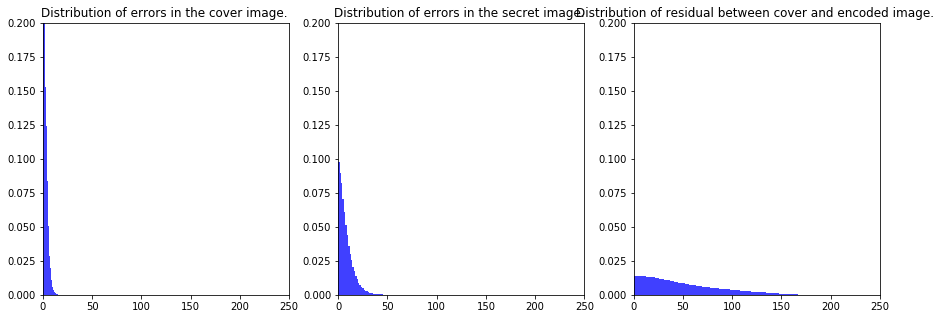

In [17]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error, encoded_C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C, encoded_C)
print("S error per pixel [0, 255]: ", S_error)
print("C error per pixel [0, 255]: ", C_error)
print("Residual error: ", encoded_C_error)

# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C, diff_encoded_C)

In [32]:
# Configs for results display
# Show images in gray scale
SHOW_GRAY = False
# Show difference between predictions and ground truth
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 5
ENHANCE1 = 1

# Number of secret and cover pairs to show.
n = 17

0 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 72x72 with 0 Axes>

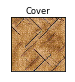

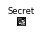

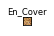

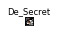

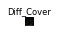

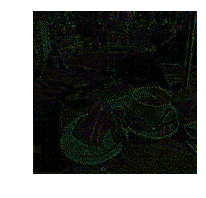

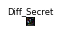

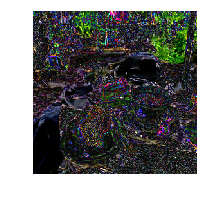

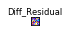

1 17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


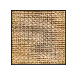

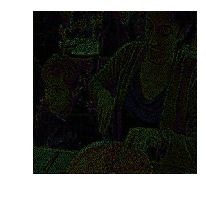

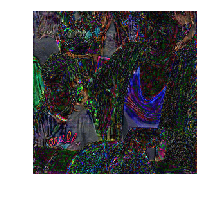

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


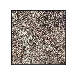

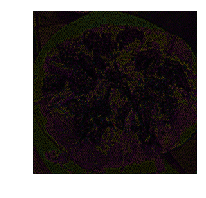

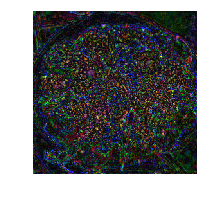

3 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


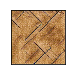

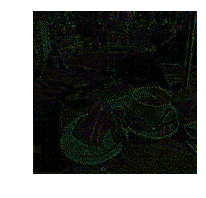

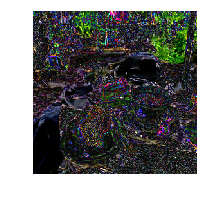

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


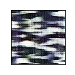

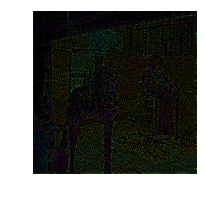

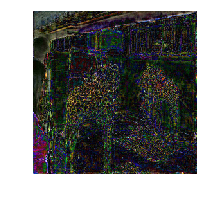

5 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


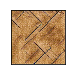

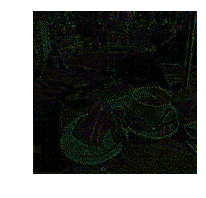

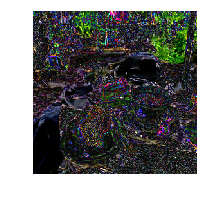

6 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


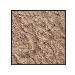

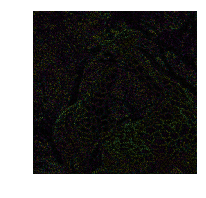

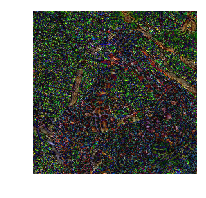

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


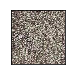

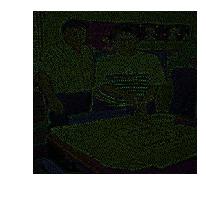

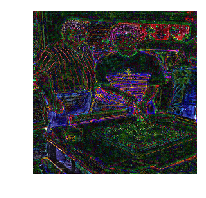

8 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


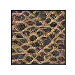

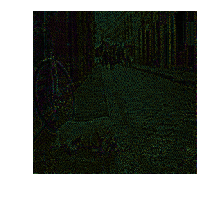

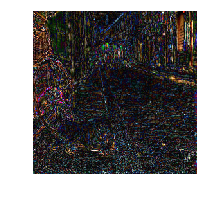

9 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


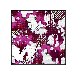

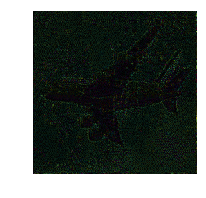

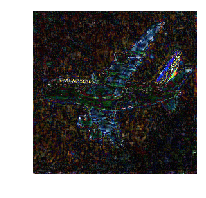

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


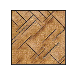

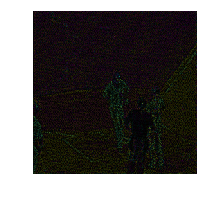

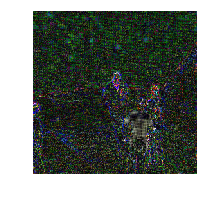

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


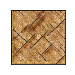

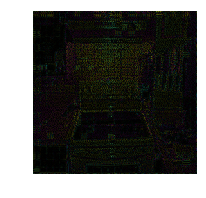

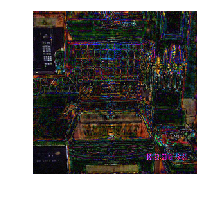

12 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


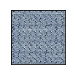

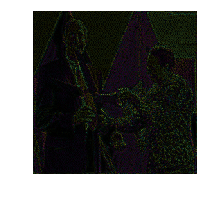

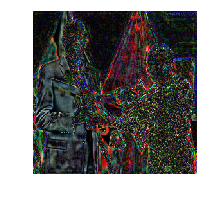

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


13 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


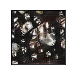

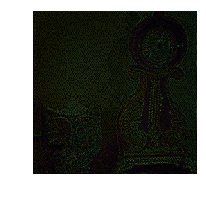

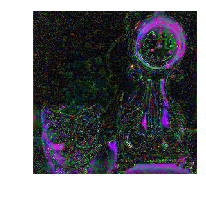

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


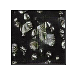

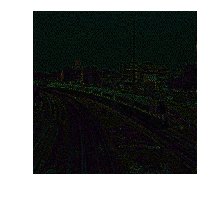

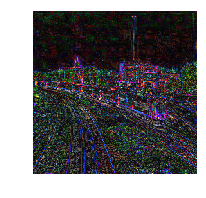

15 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


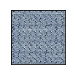

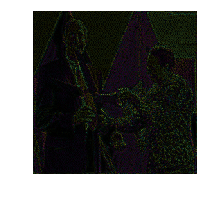

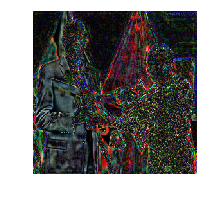

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


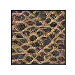

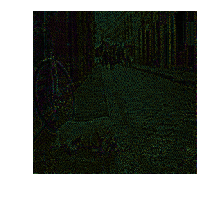

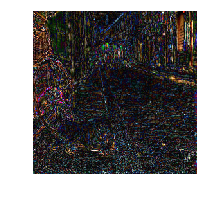

In [34]:
plt.figure(figsize=(1,1))
rand_indx = [random.randint(0,17) for x in range(n)]
# rand_indx = [x for x in range(n)]
# print (rand_indx)
# print enumerate(rand_indx)

# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    print (i, idx)
    plt.figure(figsize=(20,20))
    n_col = 7 if SHOW_DIFF else 4
#     save_image(input_C[idx])
    show_image(input_C[idx], n, n_col, i*n_col+1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    save_image(input_C[idx], idx, 'cover')
    show_image(input_S[idx], n, n_col, i*n_col+2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    save_image(input_S[idx], idx+n_col, 'secret')
    show_image(decoded_C[idx], n, n_col, i*n_col+3, gray=SHOW_GRAY, first_row=i==0, title='En_Cover')
    save_image(decoded_C[idx], idx+n_col*2, 'stego')
    show_image(decoded_S[idx], n, n_col, i*n_col+4, gray=SHOW_GRAY, first_row=i==0, title='De_Secret')
    save_image(decoded_S[idx], idx+n_col*3, 'restored')
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i*n_col+5, gray=SHOW_GRAY, first_row=i==0, title='Diff_Cover')
        save_image(np.multiply(diff_C[idx], ENHANCE), idx+n_col*4, 'diff_C')
        save_image(np.multiply(diff_C[idx], ENHANCE1), idx+n_col*5, 'diff_C1')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i*n_col+6, gray=SHOW_GRAY, first_row=i==0, title='Diff_Secret')
        save_image(np.multiply(diff_S[idx], ENHANCE), idx+n_col*6, 'diff_S')
        save_image(np.multiply(diff_S[idx], ENHANCE1), idx+n_col*7, 'diff_S1')        
        show_image(np.multiply(diff_encoded_C[idx], ENHANCE), n, n_col, i*n_col+7, gray=SHOW_GRAY, first_row=i==0, title='Diff_Residual')
#         save_image(np.multiply(diff_encoded_C[idx], ENHANCE), idx+n_col*6, 'diff_orig_encoded')
    plt.show()